In [1]:
from amuse.units import units
from amuse.lab import Huayno, nbody_system, new_galactics_model
from amuse.lab import Gadget2
from amuse.community.ph4.interface import ph4
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from amuse.couple import bridge
from amuse.community.hermite.interface import Hermite

In [2]:
%%time

# Milky Way := Mdisk = 4.5 Mbulge | Mhalo = 100 Mbulge
# Andromeda := Mdisk = 4-7 Mbulge | Mhalo = 87 Mbulge
# Mdisk = 5 Mbulge, Mhalo = 95 Mbulge

n_halo  = 4750.0
n_bulge = 50.0
n_disk  = 250.0
M_galaxy = 1e12 | units.MSun
R_galaxy = 80  | units.kpc
converter = nbody_system.nbody_to_si(M_galaxy, R_galaxy)

galaxy1 = new_galactics_model(n_halo,
                                converter,
                                do_scale=True,
                                bulge_number_of_particles=n_bulge,
                                disk_number_of_particles=n_disk)
# Order of particles: Disk => Bulge => Halo

CPU times: user 1.79 s, sys: 1.11 s, total: 2.9 s
Wall time: 3.37 s


In [3]:
%%time
M_galaxy_2 = 5e11 | units.MSun
R_galaxy_2 = 50  | units.kpc
converter_2 = nbody_system.nbody_to_si(M_galaxy_2, R_galaxy_2)
galaxy2 = new_galactics_model(n_halo,
                                converter_2,
                                do_scale=True,
                                bulge_number_of_particles=n_bulge,
                                disk_number_of_particles=n_disk)

CPU times: user 1.67 s, sys: 1.19 s, total: 2.87 s
Wall time: 3.14 s


In [4]:
%%time

converter = nbody_system.nbody_to_si(1.e12|units.MSun, 100|units.kpc)
dynamics = Gadget2(converter, number_of_workers=2)

CPU times: user 7.58 ms, sys: 14.2 ms, total: 21.8 ms
Wall time: 274 ms


In [5]:
%%time
galaxy1.rotate(0., np.pi/2, 0.)
galaxy2.x  += 400 | units.kpc
galaxy2.vx += -100 |units.kms
galaxy2.vy += +10 |units.kms

dynamics.parameters.epsilon_squared = (100|units.parsec)**2
set1 = dynamics.particles.add_particles(galaxy1)
set2 = dynamics.particles.add_particles(galaxy2)
#dynamics.particles.move_to_center()

CPU times: user 135 ms, sys: 15.5 ms, total: 151 ms
Wall time: 38.2 ms


In [6]:
%%time
n_halo_test  = 1000
n_disk_test  = 1000
n_bulge_test = 1000

test_particles_1 = new_galactics_model(n_halo_test,
                                converter,
                                do_scale=True,
                                bulge_number_of_particles=n_bulge_test,
                                disk_number_of_particles=n_disk_test)

test_particles_2 = new_galactics_model(n_halo_test,
                                converter_2,
                                do_scale=True,
                                bulge_number_of_particles=n_bulge_test,
                                disk_number_of_particles=n_disk_test)

CPU times: user 3.74 s, sys: 3.81 s, total: 7.56 s
Wall time: 7.67 s


In [7]:
test_particles_1.mass = 0 |units.kg
test_particles_2.mass = 0 |units.kg

test_particles_1_stars = test_particles_1[:int(n_halo_test+n_disk_test)]
test_particles_2_stars = test_particles_2[:int(n_halo_test+n_disk_test)]


test_particles_1_stars.rotate(0., np.pi/2, 0.)
test_particles_2_stars.x  += 400 | units.kpc
test_particles_2_stars.vx += -100 |units.kms
test_particles_2_stars.vy += +10 |units.kms

star_dynamics = Hermite(converter, number_of_workers=1)
star_set_1 = star_dynamics.particles.add_particles(test_particles_1_stars)
star_set_2 = star_dynamics.particles.add_particles(test_particles_2_stars)

In [8]:
gravity = bridge.Bridge(use_threading=False)
#gravity.add_system(dynamics)
gravity.add_system(star_dynamics, (dynamics,) )
ch_g2l = star_dynamics.particles.new_channel_to(star_dynamics.particles)

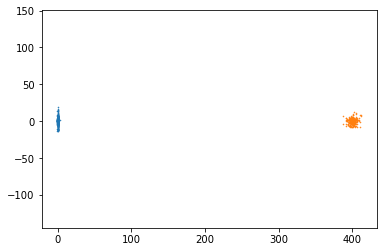

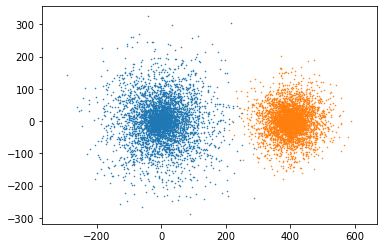

In [9]:
plt.scatter(galaxy1.x[:int(n_bulge+n_disk)].value_in(units.kpc), galaxy1.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3)
plt.scatter(galaxy2.x[:int(n_bulge+n_disk)].value_in(units.kpc), galaxy2.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3)
plt.axis("equal")
plt.show()

plt.scatter(galaxy1.x[int(n_bulge+n_disk):].value_in(units.kpc), galaxy1.y[int(n_bulge+n_disk):].value_in(units.kpc), s=0.3)
plt.scatter(galaxy2.x[int(n_bulge+n_disk):].value_in(units.kpc), galaxy2.y[int(n_bulge+n_disk):].value_in(units.kpc), s=0.3)
plt.axis("equal")
plt.show()

  0%|          | 0/5001 [00:00<?, ?it/s]

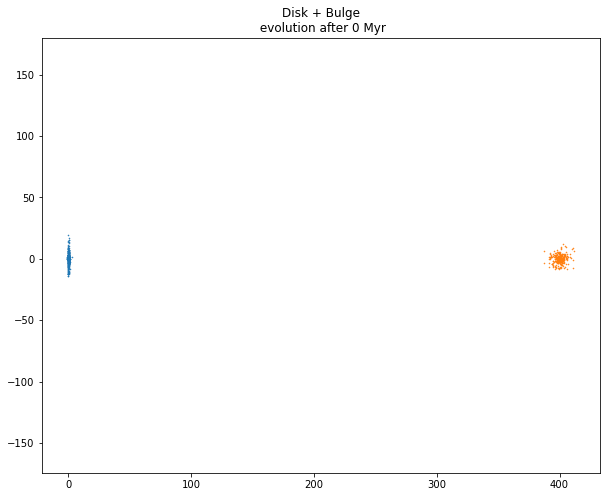

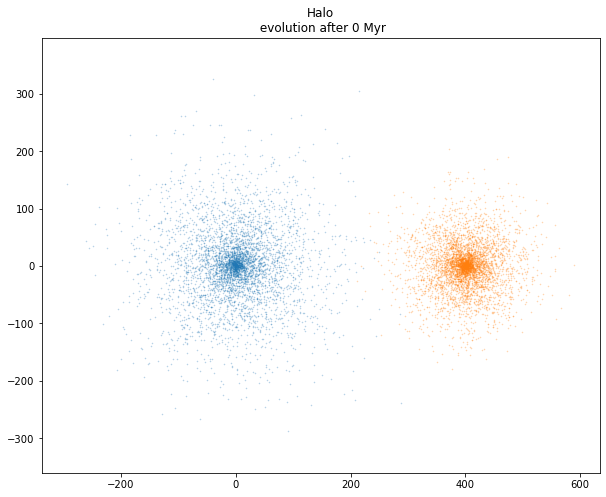

  0%|          | 1/5001 [00:00<56:52,  1.47it/s]


AmuseException: Error when calling 'get_gravity_at_point' of a 'Gadget2', errorcode is -2, error is 'Called function is not implemented.'

In [10]:
#dynamics.scale_to_standard(converter)
#gravity.particles.add_particles(dynamics.particles)
channel = dynamics.particles.new_channel_to(dynamics.particles)

times = np.arange(0, 5001, 1) | units.Myr
threshold = 500 |units.Myr 

for time in tqdm(times):
    gravity.evolve_model(time)
    channel.copy()
    if time %threshold == 0|units.Myr:
        plt.figure(figsize= (10,8))
        plt.scatter(set1.x[:int(n_bulge+n_disk)].value_in(units.kpc), set1.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3)
        #plt.scatter(set1.x[:int(n_bulge+n_disk)].value_in(units.kpc), set1.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3)
        plt.scatter(set2.x[:int(n_bulge+n_disk)].value_in(units.kpc), set2.y[:int(n_bulge+n_disk)].value_in(units.kpc), s=0.3)
        plt.title("Disk + Bulge\n evolution after " + str(time))
        plt.axis("equal")
        plt.show()

        plt.figure(figsize= (10,8))
        plt.scatter(set1.x[int(n_bulge+n_disk):].value_in(units.kpc), set1.y[int(n_bulge+n_disk):].value_in(units.kpc), s=0.3,alpha = 0.3)
        plt.scatter(set2.x[int(n_bulge+n_disk):].value_in(units.kpc), set2.y[int(n_bulge+n_disk):].value_in(units.kpc), s=0.3,alpha = 0.3)
        plt.title("Halo\n evolution after " +str(time))
        plt.axis("equal")
        plt.show()